<a href="https://colab.research.google.com/github/vvnjin/community-wellness-dashboard/blob/main/distance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is for calculation distances between various Vancouver property addresses, and various education-related buildings (eg. libraries, schools, post-secondary schools, strongstart centres, adult education centres)

All the necessary sources are located in the Community Wellness Dashboard - Dfg Google Drive.

For each electoral district, distance calculations are aggregated into median/max/mean.

Author: Vivian Jin

## Mount your Google Drive to access files

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## ADD SOURCE FILES AS SHORTCUTS TO PERSONAL GDRIVE:
It seems the only way to access shared google drives is to import the data you need into your own drive. Here I have a folder in my personal drive called 'Colab Notebooks'. I right-clicked the folders I needed and added them as shortcuts into this folder. And now I can access it.

In [ ]:
import os

# List the contents of the '/content/drive' directory
drive_path = '/content/gdrive/MyDrive/Colab Notebooks/Source Data'
drive_contents = os.listdir(drive_path)

# Find the shared drives
shared_drives = [item for item in drive_contents]
print("Shared Drives:", shared_drives)

Shared Drives: ['01 - Geographic', '02 - Education', '03 - Population']


### Import env packages

In [ ]:
import csv
import pandas as pd
from ast import literal_eval
import geopandas as gpd
from shapely.geometry import Point
import math

In [ ]:
pd.set_option('display.max_colwidth', 200)

## Read in electoral area boundaries

In [ ]:
electoral_areas = gpd.read_file("/content/gdrive/MyDrive/Colab Notebooks/Source Data/01 - Geographic/Proposed Electoral Districts/Proposed_Electoral_Districts.shp")
print(electoral_areas[electoral_areas['Area'] == 'Vancouver'].count())
electoral_areas[electoral_areas['Area'] == 'Vancouver']['Dist_Name']

OBJECTID      12
Dist_ID       12
Dist_Num      12
Dist_Name     12
Area          12
Pop2021       12
Pop2021_De    12
Pop2021_Pe    12
SqKm          12
Shape_Leng    12
Shape_Area    12
geometry      12
dtype: int64


10          Vancouver-Quilchena
11         Vancouver-Point Grey
33    Vancouver-Little Mountain
34         Vancouver-Kensington
35           Vancouver-Yaletown
36         Vancouver-Fraserview
37           Vancouver-Hastings
38            Vancouver-Renfrew
39            Vancouver-Langara
40         Vancouver-Strathcona
41           Vancouver-West End
43    Vancouver-South Granville
Name: Dist_Name, dtype: object

## Determine CRS of dataset to convert polygons accordingly into lat/lons

In [ ]:
# Source: https://catalogue.data.gov.bc.ca/dataset/current-provincial-electoral-districts-of-british-columbia

prj_file_path = '/content/gdrive/MyDrive/Colab Notebooks/Source Data/01 - Geographic/Proposed Electoral Districts/Proposed_Electoral_Districts.prj'  # Replace with the actual path to your .prj file

with open(prj_file_path, 'r') as prj_file:
    prj_contents = prj_file.read()

prj_contents

'PROJCS["Canada_Albers_Equal_Area_Conic",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers"],PARAMETER["False_Easting",1000000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-126.0],PARAMETER["Standard_Parallel_1",50.0],PARAMETER["Standard_Parallel_2",58.5],PARAMETER["Latitude_Of_Origin",45.0],UNIT["Meter",1.0]]'

## Convert polygons into lat/lons

In [ ]:
electoral_areas_wgs84 = electoral_areas.to_crs(epsg=4326)
electoral_areas_wgs84[electoral_areas_wgs84['Area'] == 'Vancouver']

,OBJECTID,Dist_ID,Dist_Num,Dist_Name,Area,Pop2021,Pop2021_De,Pop2021_Pe,SqKm,Shape_Leng,Shape_Area,geometry
10,45,81,D81,Vancouver-Quilchena,Vancouver,56957,3184,5.9%,24,25439.738318,2.422749e+07,"POLYGON ((-123.13879 49.25705, -123.13852 49.25706, -123.13838 49.25710, -123.13832 49.25714, -123.13826 49.25717, -123.13796 49.25744, -123.13765 49.25760, -123.13736 49.25770, -123.13705 49.2578..."
11,52,80,D80,Vancouver-Point Grey,Vancouver,56818,3045,5.7%,41,33521.403511,4.076840e+07,"POLYGON ((-123.16435 49.28200, -123.16435 49.27336, -123.16427 49.27348, -123.16413 49.27357, -123.16413 49.27357, -123.16393 49.27359, -123.16206 49.27356, -123.16018 49.27353, -123.15987 49.2734..."
33,43,72,D72,Vancouver-Little Mountain,Vancouver,57034,3261,6.1%,10,15525.461412,9.750991e+06,"POLYGON ((-123.10544 49.27291, -123.10545 49.27277, -123.10310 49.27271, -123.10308 49.27297, -123.10163 49.27300, -123.10119 49.27300, -123.10010 49.27283, -123.10002 49.27282, -123.10002 49.2727..."
34,44,76,D76,Vancouver-Kensington,Vancouver,58593,4820,9.0%,9,14513.737196,8.684160e+06,"POLYGON ((-123.05258 49.23933, -123.05201 49.23905, -123.05164 49.23889, -123.05156 49.23885, -123.05032 49.23827, -123.04881 49.23757, -123.04763 49.23706, -123.04669 49.23670, -123.04590 49.2364..."
35,46,73,D73,Vancouver-Yaletown,Vancouver,55307,1534,2.9%,4,9684.451625,3.526984e+06,"POLYGON ((-123.09915 49.28735, -123.09920 49.28676, -123.09930 49.28570, -123.09929 49.28557, -123.09918 49.28543, -123.09892 49.28525, -123.09882 49.28509, -123.09882 49.28493, -123.09918 49.2848..."
36,47,74,D74,Vancouver-Fraserview,Vancouver,58686,4913,9.1%,12,16991.654375,1.160564e+07,"POLYGON ((-123.04309 49.23291, -123.04309 49.23248, -123.04310 49.23235, -123.04310 49.23197, -123.04311 49.23177, -123.04312 49.23156, -123.04315 49.23110, -123.04315 49.23110, -123.04315 49.2306..."
37,48,75,D75,Vancouver-Hastings,Vancouver,58095,4322,8.0%,14,14998.631891,1.368895e+07,"POLYGON ((-123.03850 49.29564, -123.03005 49.29507, -123.02881 49.29499, -123.02876 49.29499, -123.02633 49.29483, -123.02615 49.29481, -123.02615 49.29481, -123.02330 49.29462, -123.02330 49.2944..."
38,49,77,D77,Vancouver-Renfrew,Vancouver,56922,3149,5.9%,8,12517.792027,8.020129e+06,"POLYGON ((-123.05476 49.25751, -123.05386 49.25748, -123.05344 49.25749, -123.05295 49.25751, -123.05227 49.25756, -123.05212 49.25758, -123.05182 49.25761, -123.05041 49.25778, -123.04957 49.2578..."
39,50,78,D78,Vancouver-Langara,Vancouver,55724,1951,3.6%,12,17493.658710,1.249294e+07,"POLYGON ((-123.13068 49.23403, -123.13038 49.23402, -123.12808 49.23396, -123.12808 49.23396, -123.12808 49.23389, -123.12811 49.23301, -123.12815 49.23209, -123.12822 49.23021, -123.12823 49.2293..."
40,51,79,D79,Vancouver-Strathcona,Vancouver,54588,815,1.5%,12,17890.159927,1.212728e+07,"POLYGON ((-123.10289 49.28831, -123.10268 49.30127, -123.10246 49.30119, -123.10067 49.30050, -123.09937 49.30000, -123.09833 49.29960, -123.09512 49.29939, -123.09487 49.29937, -123.09213 49.2991..."


## Read in Vancouver libraries

In [ ]:
# Source: https://opendata.vancouver.ca/explore/dataset/libraries/information/

libraries_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Source Data/02 - Education/vancouver_libraries_from_opendata.csv", delimiter=';')
libraries_df.head()

,ADDRESS,NAME,URLLINK,Geom,Geo Local Area,geo_point_2d
0,2985 Kingsway,Collingwood,http://www.vpl.ca/branches/details/collingwood_branch,"{""coordinates"": [-123.0426, 49.2362], ""type"": ""Point""}",Renfrew-Collingwood,"49.2362, -123.0426"
1,1950 Argyle Drive,Fraserview,http://www.vpl.ca/branches/details/fraserview_branch,"{""coordinates"": [-123.0669, 49.2197], ""type"": ""Point""}",Victoria-Fraserview,"49.2197, -123.0669"
2,870 Denman St,Joe Fortes,http://www.vpl.ca/branches/details/joe_fortes_branch,"{""coordinates"": [-123.1361, 49.2899], ""type"": ""Point""}",West End,"49.2899, -123.1361"
3,2112 W 42nd Av,Kerrisdale,http://www.vpl.ca/branches/details/kerrisdale_branch,"{""coordinates"": [-123.1571, 49.2332], ""type"": ""Point""}",Kerrisdale,"49.2332, -123.1571"
4,8386 Granville St,Marpole,http://www.vpl.ca/branches/details/marpole_branch,"{""coordinates"": [-123.14, 49.2104], ""type"": ""Point""}",Marpole,"49.2104, -123.14"


In [ ]:
# Convert string geopoints to Point objects
def convert_to_point(coord_string):
    latitude, longitude = map(float, coord_string.split(', '))
    return Point(longitude, latitude)

libraries_df['geopoints'] = libraries_df['geo_point_2d'].apply(lambda x: convert_to_point(x))
libraries_df['geopoints'].head(5)

0    POINT (-123.0426 49.2362)
1    POINT (-123.0669 49.2197)
2    POINT (-123.1361 49.2899)
3    POINT (-123.1571 49.2332)
4      POINT (-123.14 49.2104)
Name: geopoints, dtype: object

In [ ]:
# Determine which electoral areas each point belongs to, store in 'electoral_area' column
def get_containing_polygons(point, polygons):
    contained = polygons['geometry'].contains(point)
    return ', '.join(polygons.loc[contained, 'Dist_Name']) if not polygons.loc[contained, 'Dist_Name'].empty else 'None'

libraries_df['electoral_area'] = libraries_df['geopoints'].apply(lambda x: get_containing_polygons(x, electoral_areas_wgs84))

libraries_df[['NAME','geopoints', 'electoral_area']]

,NAME,geopoints,electoral_area
0,Collingwood,POINT (-123.0426 49.2362),Vancouver-Renfrew
1,Fraserview,POINT (-123.0669 49.2197),Vancouver-Fraserview
2,Joe Fortes,POINT (-123.1361 49.2899),Vancouver-West End
3,Kerrisdale,POINT (-123.1571 49.2332),Vancouver-Quilchena
4,Marpole,POINT (-123.14 49.2104),Vancouver-Langara
5,Outreach Services,POINT (-123.1156 49.2797),Vancouver-Yaletown
6,Renfrew,POINT (-123.043 49.2524),Vancouver-Renfrew
7,Britannia,POINT (-123.0738 49.2756),Vancouver-Strathcona
8,Carnegie,POINT (-123.1001 49.2811),Vancouver-Strathcona
9,Central Branch,POINT (-123.1156 49.2797),Vancouver-Yaletown


## Read in Vancouver schools

In [ ]:
# Source: opendata.vancouver.ca/explore/dataset/

schools_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Source Data/02 - Education/vancouver_schools_from_opendata.csv", delimiter=';')
schools_df[schools_df['SCHOOL_CATEGORY'] == 'StrongStart BC']

## EXCLUDE StrongStart schools - they are outdated, we will use a better StrongStart data below
## EXCLUDE Westside School - it closed down
schools_df = schools_df[schools_df['SCHOOL_CATEGORY'] != 'StrongStart BC']
schools_df = schools_df[~schools_df['SCHOOL_NAME'].str.contains('The Westside School')]

schools_df

,ADDRESS,SCHOOL_CATEGORY,SCHOOL_NAME,Geom,Geo Local Area,geo_point_2d
0,1110 Cotton Drive,Public School,Britannia Community Elementary,"{""coordinates"": [-123.07137879542154, 49.27451200859733], ""type"": ""Point""}",Grandview-Woodland,"49.27451200859733, -123.07137879542154"
1,7835 Champlain Crescent,Public School,Champlain Heights Annex,"{""coordinates"": [-123.03054968939806, 49.2140784317513], ""type"": ""Point""}",Killarney,"49.2140784317513, -123.03054968939806"
3,3877 Glen Drive,Public School,Charles Dickens Annex,"{""coordinates"": [-123.08271031, 49.2502130610676], ""type"": ""Point""}",Kensington-Cedar Cottage,"49.2502130610676, -123.08271031"
4,3200 W 41st Av,Independent School,Crofton House,"{""coordinates"": [-123.17721815907593, 49.233677833584544], ""type"": ""Point""}",Kerrisdale,"49.233677833584544, -123.17721815907593"
5,315 E 23rd Av,Public School,David Livingstone Elementary,"{""coordinates"": [-123.09798144, 49.2507533360676], ""type"": ""Point""}",Riley Park,"49.2507533360676, -123.09798144"
...,...,...,...,...,...,...
189,1545 W 62nd Av,Independent School,Vancouver Hebrew Academy,"{""coordinates"": [-123.1413692647842, 49.21547172757715], ""type"": ""Point""}",Marpole,"49.21547172757715, -123.1413692647842"
190,8650 Barnard St,Independent School,Vancouver Montessori School,"{""coordinates"": [-123.14463359946043, 49.20779039590787], ""type"": ""Point""}",Marpole,"49.20779039590787, -123.14463359946043"
191,1000 E 59th Av,Public School,Walter Moberly Elementary,"{""coordinates"": [-123.08434542, 49.216109230067424], ""type"": ""Point""}",Sunset,"49.216109230067424, -123.08434542"
192,3075 Slocan St,Independent School,Westside Montessori Academy,"{""coordinates"": [-123.0503919492473, 49.256937847571606], ""type"": ""Point""}",Renfrew-Collingwood,"49.256937847571606, -123.0503919492473"


In [ ]:
# Convert string geopoints to Point objects
schools_df['geopoints'] = schools_df['geo_point_2d'].apply(lambda x: convert_to_point(x))

# Determine which electoral areas each point belongs to, store in 'electoral_area' column
schools_df['electoral_area'] = schools_df['geopoints'].apply(lambda x: get_containing_polygons(x, electoral_areas_wgs84))
schools_df[['SCHOOL_NAME','geopoints', 'electoral_area']]

# Export data for quick access
schools_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Intermediate Data/02 - Education/schools_with_electoral_area_and_geopoints.csv')


## Read in catchment area zones (but currently not using them)

In [ ]:
elementary_catchment_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Source Data/01 - Geographic/Catchment Areas/elementary_school_attendance_area_boundary.csv")
elementary_catchment_df

secondary_catchment_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Source Data/01 - Geographic/Catchment Areas/secondary_school_attendance_area_boundary.csv")
secondary_catchment_df


,X,Y,OBJECTID,Shape_Length,Shape_Area,Secondary_School,area_km,area_m
0,-123.062272,49.263878,1,17967.870087,8.240348e+06,Vancouver Technical,8.240348,8.240348e+06
1,-123.125932,49.283039,3,11075.274014,4.772842e+06,King George,4.772842,4.772842e+06
2,-123.087024,49.278512,5,17330.584308,5.804310e+06,Britannia,5.804310,5.804310e+06
3,-123.044493,49.281437,7,12458.608031,6.962700e+06,Templeton,6.962700,6.962700e+06
4,-123.230051,49.257315,9,18709.586520,1.387022e+07,University Hill,13.870221,1.387022e+07
5,-123.184747,49.228934,11,18153.059303,9.607385e+06,Point Grey,9.607385,9.607385e+06
6,-123.199825,49.260084,13,15501.744645,6.991567e+06,Byng,6.991567,6.991567e+06
7,-123.160248,49.268034,15,17551.998383,8.044363e+06,Kitsilano,8.044363,8.044363e+06
8,-123.158798,49.250331,17,9328.502482,4.892352e+06,Prince of Wales,4.892352,4.892352e+06
9,-123.154263,49.218632,19,11504.089286,5.571862e+06,Magee,5.571862,5.571862e+06


## Read in StrongStart BC Locations

In [ ]:
# Source: https://catalogue.data.gov.bc.ca/dataset/strongstart-bc-centre-locations

strongstart_schools_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Source Data/02 - Education/StrongStart Schools.csv", delimiter=',')
strongstart_schools_df = strongstart_schools_df[strongstart_schools_df['FACILITY_CITY'] == 'Vancouver']
strongstart_schools_df

,SCHOOL_DISTRICT_NUMBER,SCHOOL_DISTRICT_NAME,PROGRAM_NUMBER,PROGRAM_TYPE,FACILITY_NAME,FACILITY_ADDRESS,FACILITY_CITY,FACILITY_POSTAL_CODE,PROGRAM_PHONE_NUMBER,PROGRAM_FAX_NUMBER,LATITUDE,LONGITUDE
3,39,Vancouver,3925416,Early Learning Program,Admiral Seymour StrongStart Centre,1130 Keefer St,Vancouver,V6A 1Z3,604 713-4641,NaN,49.278679,-123.080289
30,39,Vancouver,3925252,Early Learning Program,Captain James Cook StrongStart Centre,3340 54th Ave E,Vancouver,V5S 1Z3,604 713-4828,NaN,49.219351,-123.036263
45,39,Vancouver,3925251,Early Learning Program,Champlain Heights Annex StrongStart Cntr,7835 Champlain Cres,Vancouver,V5S 4J6,604 713-4880,NaN,49.213734,-123.030915
52,39,Vancouver,3925127,Early Learning Program,Collingwood AM StrongStart Centre,3417 Euclid Ave,Vancouver,V5R 6H2,604 713-5340,604 713-5339,49.236375,-123.032285
53,39,Vancouver,3925248,Early Learning Program,Collingwood PM StrongStart Centre,3417 Euclid Ave,Vancouver,V5R 6H2,604 713-4595,604 713-5339,49.236375,-123.032285
90,39,Vancouver,3925122,Early Learning Program,Florence Nightingale StrongStart Centre,2740 Guelph St,Vancouver,V5T 3P7,604 713-5290,NaN,49.260225,-123.094421
93,93,Conseil scolaire francophone,9325187,Early Learning Program,Franc Depart Anne-Hebert StrongStart,7051 Killarney St,Vancouver,V5S 2Y5,604 736-5056,NaN,49.219238,-123.045853
142,39,Vancouver,3925436,Early Learning Program,John Henderson StrongStart Centre,451 53rd Ave E,Vancouver,V5X 1J3,604 713-4837,NaN,49.222735,-123.095076
157,39,Vancouver,3925042,Early Learning Program,Lord Selkirk StrongStart Centre,1750 22nd Ave E,Vancouver,V5N 2P7,604 713-4650,604 713-4657,49.249687,-123.069023
185,39,Vancouver,3925253,Early Learning Program,Mount Pleasant StrongStart Centre,2300 Guelph St,Vancouver,V5T 3P1,604 713-4617,NaN,49.263933,-123.094346


In [ ]:
# Convert string geopoints to Point objects
strongstart_schools_df['geopoints'] = [Point(xy) for xy in zip(strongstart_schools_df['LONGITUDE'], strongstart_schools_df['LATITUDE'])]

# Determine which electoral areas each point belongs to, store in 'electoral_area' column
strongstart_schools_df['electoral_area'] = strongstart_schools_df['geopoints'].apply(lambda x: get_containing_polygons(x, electoral_areas_wgs84))
strongstart_schools_df[['FACILITY_NAME','geopoints', 'electoral_area']]

,FACILITY_NAME,geopoints,electoral_area
3,Admiral Seymour StrongStart Centre,POINT (-123.0802888 49.2786789),Vancouver-Strathcona
30,Captain James Cook StrongStart Centre,POINT (-123.0362627 49.21935071),Vancouver-Fraserview
45,Champlain Heights Annex StrongStart Cntr,POINT (-123.0309152 49.21373351),Vancouver-Fraserview
52,Collingwood AM StrongStart Centre,POINT (-123.0322852 49.2363748),Vancouver-Renfrew
53,Collingwood PM StrongStart Centre,POINT (-123.0322852 49.2363748),Vancouver-Renfrew
90,Florence Nightingale StrongStart Centre,POINT (-123.0944211 49.26022459),Vancouver-Strathcona
93,Franc Depart Anne-Hebert StrongStart,POINT (-123.0458532 49.21923821),Vancouver-Fraserview
142,John Henderson StrongStart Centre,POINT (-123.0950757 49.2227349),Vancouver-Langara
157,Lord Selkirk StrongStart Centre,POINT (-123.0690232 49.24968731),Vancouver-Strathcona
185,Mount Pleasant StrongStart Centre,POINT (-123.0943456 49.26393339),Vancouver-Strathcona


## Read in Post-Secondary Locations



In [ ]:
# Source: https://catalogue.data.gov.bc.ca/dataset/locations-of-b-c-post-secondary-institutions

postsecondary_schools_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Source Data/02 - Education/loc1-locations-of-bc-public-private-and-theological-post-secondary-institutions.csv", delimiter=',')
postsecondary_schools_df = postsecondary_schools_df[postsecondary_schools_df['City'] == 'Vancouver']
postsecondary_schools_df

,Institution,Location,Institution Type,Economic Development Region,City,Address,Location Description,Latitude,Longitude
4,British Columbia Institute of Technology,Downtown,Public Post-Secondary,Mainland/Southwest,Vancouver,555 Seymour St,Campus,49.283508,-123.115259
5,British Columbia Institute of Technology,Centre for Digital Media,Public Post-Secondary,Mainland/Southwest,Vancouver,685 Great Northern Way,Shared Campus,49.267050,-123.089574
34,Emily Carr University of Art and Design,Main Campus,Public Post-Secondary,Mainland/Southwest,Vancouver,520 East 1st Ave,Main Campus,49.267516,-123.092452
35,Emily Carr University of Art and Design,Centre for Digital Media,Public Post-Secondary,Mainland/Southwest,Vancouver,685 Great Northern Way,Shared Campus,49.267050,-123.089574
47,Langara College,Main Campus,Public Post-Secondary,Mainland/Southwest,Vancouver,100 West 49th Avenue,Main Campus,49.224568,-123.108437
48,Langara College,West Broadway Centre,Public Post-Secondary,Mainland/Southwest,Vancouver,601 West Broadway,Campus,49.263736,-123.118004
77,Simon Fraser University,Centre for Digital Media,Public Post-Secondary,Mainland/Southwest,Vancouver,685 Great Northern Way,Shared Campus,49.267050,-123.089574
80,Simon Fraser University,Vancouver Campus,Public Post-Secondary,Mainland/Southwest,Vancouver,515 West Hastings Street,Campus,49.284542,-123.111646
86,University of British Columbia,Centre for Digital Media,Public Post-Secondary,Mainland/Southwest,Vancouver,685 Great Northern Way,Shared Campus,49.267050,-123.089574
87,University of British Columbia,Vancouver Campus,Public Post-Secondary,Mainland/Southwest,Vancouver,2329 West Mall,Main Campus,49.260789,-123.252933


In [ ]:
# Convert string geopoints to Point objects
postsecondary_schools_df['geopoints'] = [Point(xy) for xy in zip(postsecondary_schools_df['Longitude'], postsecondary_schools_df['Latitude'])]
postsecondary_schools_df['institution_and_location'] = [str(x) + " - " + str(y) for x, y in zip(postsecondary_schools_df['Institution'], postsecondary_schools_df['Location'])]

# Determine which electoral areas each point belongs to, store in 'electoral_area' column
postsecondary_schools_df['electoral_area'] = postsecondary_schools_df['geopoints'].apply(lambda x: get_containing_polygons(x, electoral_areas_wgs84))
postsecondary_schools_df[['institution_and_location','geopoints', 'electoral_area']]

,institution_and_location,geopoints,electoral_area
4,British Columbia Institute of Technology - Downtown,POINT (-123.115259 49.283508),Vancouver-Yaletown
5,British Columbia Institute of Technology - Centre for Digital Media,POINT (-123.089574 49.26705),Vancouver-Strathcona
34,Emily Carr University of Art and Design - Main Campus,POINT (-123.092452 49.267516),Vancouver-Strathcona
35,Emily Carr University of Art and Design - Centre for Digital Media,POINT (-123.089574 49.26705),Vancouver-Strathcona
47,Langara College - Main Campus,POINT (-123.108437 49.2245678),Vancouver-Langara
48,Langara College - West Broadway Centre,POINT (-123.1180045 49.2637363),Vancouver-South Granville
77,Simon Fraser University - Centre for Digital Media,POINT (-123.089574 49.26705),Vancouver-Strathcona
80,Simon Fraser University - Vancouver Campus,POINT (-123.1116459 49.2845416),Vancouver-Yaletown
86,University of British Columbia - Centre for Digital Media,POINT (-123.089574 49.26705),Vancouver-Strathcona
87,University of British Columbia - Vancouver Campus,POINT (-123.252933 49.260789),Vancouver-Point Grey


## Read in Adult Education Centres

In [ ]:
# Source: https://catalogue.data.gov.bc.ca/dataset/adult-education-institutions

adult_education_schools_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Source Data/02 - Education/bc-adult-education-institutions-data-sheet-july2020.csv", delimiter=',')
adult_education_schools_df = adult_education_schools_df[adult_education_schools_df['City'] == 'Vancouver']
adult_education_schools_df

,Institution,Campus_District,Institution_type,Ec_Dev_Region,City,Address,Postal_Code,Latitude,Longitude,Dept_Email,Dept_Phone,Link
29,Langara College,Vancouver Campus,Post-Secondary,Metro Vancouver Regional District (MVRD),Vancouver,100 West 49th Avenue,V5Y 2Z6,49.224837,-123.108787,admissions@langara.ca,604.323.5511,\nhttps://langara.ca/admissions/index.html
30,Vancouver Community College,Broadway Youth Resource Centre (for ages 15-18),Post-Secondary,Metro Vancouver Regional District (MVRD),Vancouver,#215 – 2455 Fraser Street,V5T 0E6,49.263575,-123.089707,ABEYouth@vcc.ca,604-709-5720,http://www.vcc.ca/programscourses/program-areas/academic-upgrading--high-school/adult-basic-education-abe-intermediate-program-for-youth/
31,Vancouver Community College,VCC Broadway Campus,Post-Secondary,Metro Vancouver Regional District (MVRD),Vancouver,1155 East Broadway,V5T 4V5,49.263541,-123.080911,NaN,1.866.565.7820,\nhttp://www.vcc.ca/programscourses/program-areas/academic-upgrading--high-school/
86,VSB Adult Education,Adult Education SD#39,Continuing Education Centre,Mainland/ Southwest,Vancouver,6010 Fraser St,V5W 2Z7,49.230013,-123.090324,NaN,604 713-5770,http://go.vsb.bc.ca/schools/adulted/Pages/default.aspx


In [ ]:
# Convert string geopoints to Point objects
adult_education_schools_df['geopoints'] = [Point(xy) for xy in zip(adult_education_schools_df['Longitude'], adult_education_schools_df['Latitude'])]
adult_education_schools_df['institution_and_location'] = [str(x) + " - " + str(y) for x, y in zip(adult_education_schools_df['Institution'], adult_education_schools_df['Campus_District'])]

# Determine which electoral areas each point belongs to, store in 'electoral_area' column
adult_education_schools_df['electoral_area'] = adult_education_schools_df['geopoints'].apply(lambda x: get_containing_polygons(x, electoral_areas_wgs84))
adult_education_schools_df[['institution_and_location','geopoints', 'electoral_area']]

,institution_and_location,geopoints,electoral_area
29,Langara College - Vancouver Campus,POINT (-123.108787 49.224837),Vancouver-Langara
30,Vancouver Community College - Broadway Youth Resource Centre (for ages 15-18),POINT (-123.089707 49.263575),Vancouver-Strathcona
31,Vancouver Community College - VCC Broadway Campus,POINT (-123.080911 49.263541),Vancouver-Strathcona
86,VSB Adult Education - Adult Education SD#39,POINT (-123.090324 49.230013),Vancouver-Kensington


## Read in residential property data

In [ ]:
# Source: https://opendata.vancouver.ca/explore/dataset/property-addresses/information/

properties_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Source Data/01 - Geographic/property-addresses.csv", delimiter=';')
print(properties_df.count())
properties_df.head(5)

CIVIC_NUMBER       98961
Geo Local Area    100090
Geom              100158
P_PARCEL_ID       100158
PCOORD             99641
SITE_ID            99278
STD_STREET         98961
geo_point_2d      100158
dtype: int64


,CIVIC_NUMBER,Geo Local Area,Geom,P_PARCEL_ID,PCOORD,SITE_ID,STD_STREET,geo_point_2d
0,3820.0,Riley Park,"{""coordinates"": [-123.11490146788236, 49.25098806714351], ""type"": ""Point""}",__FIYNSI,17070302.0,013373935,CAMBIE ST,"49.25098806714351, -123.11490146788236"
1,3870.0,Riley Park,"{""coordinates"": [-123.11492935977854, 49.25052524399389], ""type"": ""Point""}",__FIYNSS,17070376.0,013374001,CAMBIE ST,"49.25052524399389, -123.11492935977854"
2,489.0,Riley Park,"{""coordinates"": [-123.11494521823988, 49.25025357236029], ""type"": ""Point""}",__FIYNSW,17070392.0,011534630,W 23RD AV,"49.25025357236029, -123.11494521823988"
3,455.0,Riley Park,"{""coordinates"": [-123.11396767168794, 49.25036520008657], ""type"": ""Point""}",__FIYNT6,70717051.0,013374176,W 23RD AV,"49.25036520008657, -123.11396767168794"
4,425.0,Riley Park,"{""coordinates"": [-123.11341663526409, 49.250354507306696], ""type"": ""Point""}",__FIYNTE,70717075.0,013374231,W 23RD AV,"49.250354507306696, -123.11341663526409"


## Filter properties by residential zones

In [ ]:
properties_with_zones_df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Source Data/01 - Geographic/Residential Zones/properties_address_zoning.csv")
properties_with_zones_df = properties_with_zones_df[["p_parcel_i", "zoning_clas"]]
properties_with_zones_df = properties_with_zones_df.rename(columns={'p_parcel_i': 'P_PARCEL_ID', 'zoning_clas': 'zoning_class'})

merged_properties_df = properties_with_zones_df.merge(properties_df, on='P_PARCEL_ID')
print(len(merged_properties_df))
print(len(properties_df))

residential_properties_df = merged_properties_df[merged_properties_df['zoning_class'].str.contains('Residential')]
residential_properties_df

100050
100158


,P_PARCEL_ID,zoning_class,CIVIC_NUMBER,Geo Local Area,Geom,PCOORD,SITE_ID,STD_STREET,geo_point_2d
1,__FIZBCY,Residential Inclusive,472.0,Sunset,"{""coordinates"": [-123.09577912520002, 49.219786435933905], ""type"": ""Point""}",80519768.0,012813095,E 55TH AV,"49.219786435933905, -123.09577912520002"
2,__FJ0OSS,Residential Inclusive,3466.0,Hastings-Sunrise,"{""coordinates"": [-123.02938420077632, 49.27977421719474], ""type"": ""Point""}",59230068.0,014461854,E PENDER ST,"49.27977421719474, -123.02938420077632"
3,__FJ0C40,Residential Inclusive,6538.0,Oakridge,"{""coordinates"": [-123.12631570647622, 49.22583665973159], ""type"": ""Point""}",15279028.0,010036792,FREMLIN ST,"49.22583665973159, -123.12631570647622"
4,__FJ1OIW,Residential Inclusive,3137.0,Kerrisdale,"{""coordinates"": [-123.17482749690254, 49.23403022329791], ""type"": ""Point""}",75205431.0,010105051,W 42ND AV,"49.23403022329791, -123.17482749690254"
5,__FJ0UP0,Residential Inclusive,719.0,Kensington-Cedar Cottage,"{""coordinates"": [-123.08956727857316, 49.241094554357716], ""type"": ""Point""}",72921019.0,014122502,DURWARD AV,"49.241094554357716, -123.08956727857316"
...,...,...,...,...,...,...,...,...,...
100043,__FJ0NOG,Residential Inclusive,1270.0,Shaughnessy,"{""coordinates"": [-123.13379066278841, 49.24893093840021], ""type"": ""Point""}",71014412.0,011074001,W KING EDWARD AV,"49.24893093840021, -123.13379066278841"
100044,__FJ1EJE,Residential Inclusive,4550.0,Dunbar-Southlands,"{""coordinates"": [-123.19342093135809, 49.24551444344841], ""type"": ""Point""}",72303207.0,007237367,CROWN ST,"49.24551444344841, -123.19342093135809"
100046,__FJ0UU6,Residential,5078.0,Kensington-Cedar Cottage,"{""coordinates"": [-123.09005379737397, 49.23860215214136], ""type"": ""Point""}",21073082.0,VAS2127,FRASER ST,"49.23860215214136, -123.09005379737397"
100047,__FJ0XMU,Residential Inclusive,51.0,Sunset,"{""coordinates"": [-123.10470812279854, 49.23194620442233], ""type"": ""Point""}",75318439.0,014450861,E 42ND AV,"49.23194620442233, -123.10470812279854"


In [ ]:
# Convert string geopoints to Point objects
properties_df = residential_properties_df
properties_df['geopoints'] = properties_df['geo_point_2d'].apply(lambda x: convert_to_point(x))

# Determine which electoral areas each point belongs to, store in 'electoral_area' column
properties_df['electoral_area'] = properties_df['geopoints'].apply(lambda x: get_containing_polygons(x, electoral_areas_wgs84))
properties_df[['Geo Local Area','geopoints', 'electoral_area']]

<ipython-input-118-00bd32420a3a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties_df['geopoints'] = properties_df['geo_point_2d'].apply(lambda x: convert_to_point(x))
<ipython-input-118-00bd32420a3a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties_df['electoral_area'] = properties_df['geopoints'].apply(lambda x: get_containing_polygons(x, electoral_areas_wgs84))


,Geo Local Area,geopoints,electoral_area
1,Sunset,POINT (-123.09577912520002 49.219786435933905),Vancouver-Langara
2,Hastings-Sunrise,POINT (-123.02938420077632 49.27977421719474),Vancouver-Hastings
3,Oakridge,POINT (-123.12631570647622 49.22583665973159),Vancouver-Langara
4,Kerrisdale,POINT (-123.17482749690254 49.23403022329791),Vancouver-Quilchena
5,Kensington-Cedar Cottage,POINT (-123.08956727857316 49.241094554357716),Vancouver-Kensington
...,...,...,...
100043,Shaughnessy,POINT (-123.13379066278841 49.24893093840021),Vancouver-Quilchena
100044,Dunbar-Southlands,POINT (-123.19342093135809 49.24551444344841),Vancouver-Quilchena
100046,Kensington-Cedar Cottage,POINT (-123.09005379737397 49.23860215214136),Vancouver-Kensington
100047,Sunset,POINT (-123.10470812279854 49.23194620442233),Vancouver-Kensington


In [ ]:
# 'Burnaby South-Metrotown' and 'Richmond-Bridgeport' electoral area properties
properties_df = properties_df[(properties_df['electoral_area']!= 'Burnaby South-Metrotown') & (properties_df['electoral_area']!= 'Richmond-Bridgeport')]

# Distribution of properties by electoral area
properties_df[['geopoints', 'electoral_area']].groupby("electoral_area").count()

,geopoints
electoral_area,
Vancouver-Fraserview,8284
Vancouver-Hastings,11618
Vancouver-Kensington,11271
Vancouver-Langara,9070
Vancouver-Little Mountain,7394
Vancouver-Point Grey,8477
Vancouver-Quilchena,13770
Vancouver-Renfrew,9422
Vancouver-South Granville,2885


## Define distance functions



In [ ]:
import math

def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

    # Radius of the Earth in kilometers (mean value)
    R = 6371.0

    # Calculate the distance
    distance = R * c

    return distance


## Testing distance formula

In [ ]:
distance = haversine(49.2438, -123.1079, 49.25098806714351, -123.11490146788236)  # Example: Berlin to Paris
print(f"The distance is {distance} kilometers.")


The distance is 0.9471689391693027 kilometers.


## For each location type, get closest location with location name, electoral area, and the distance

In [ ]:
def find_closest_school_or_library(place_type, library_locations, address_loc):
    closest_library = None
    min_distance = float('inf')
    closest_library_name = None
    closest_library_geo_area = None

    for index, library_row in library_locations.iterrows():
        library_loc = literal_eval(library_row['geo_point_2d'])
        if place_type == 'LIBRARIES':
            library_name = library_row['NAME']
        elif place_type == 'STRONGSTART':
          library_name = library_row['FACILITY_NAME']
        elif place_type == 'SCHOOLS':
            library_name = library_row['SCHOOL_NAME']
        else:
            library_name = library_row['institution_and_location']

        library_electoral_area = library_row['electoral_area']
        distance = haversine(*address_loc, *library_loc)
        if distance < min_distance:
            min_distance = distance
            closest_library = library_loc
            closest_library_name = library_name
            closest_library_electoral_area = library_electoral_area

    return closest_library_name, closest_library_electoral_area, str(closest_library), min_distance

In [ ]:
libraries_df['lat_lon'] = libraries_df['geo_point_2d'].apply(literal_eval)
properties_df['lat_lon'] = properties_df['geo_point_2d'].apply(literal_eval)

#libraries = libraries_df['lat_lon'].tolist()  # List of library locations
#properties = properties_df['lat_lon'].tolist() # List of addresses

libraries = libraries_df[["NAME", "electoral_area", 'geo_point_2d']]

for index, row in properties_df.iterrows():
    closest_library_name, closest_library_electoral_area, closest_library, closest_library_dist_km = find_closest_school_or_library("LIBRARIES", libraries, literal_eval(row['geo_point_2d']))
    properties_df.loc[index, 'closest_library_name'] = closest_library_name
    properties_df.loc[index, 'closest_library_electoral_area'] = closest_library_electoral_area
    properties_df.loc[index, 'closest_library'] = closest_library
    properties_df.loc[index, 'closest_library_dist_km'] = closest_library_dist_km
    #print(properties_df.loc[index])

In [ ]:
schools_df['lat_lon'] = schools_df['geo_point_2d'].apply(literal_eval)
properties_df['lat_lon'] = properties_df['geo_point_2d'].apply(literal_eval)

#libraries = libraries_df['lat_lon'].tolist()  # List of library locations
#properties = properties_df['lat_lon'].tolist() # List of addresses

schools = schools_df[["SCHOOL_NAME", "electoral_area", 'geo_point_2d']]

for index, row in properties_df.iterrows():
    closest_school_name, closest_school_electoral_area, closest_school, closest_school_dist_km = find_closest_school_or_library("SCHOOLS", schools, literal_eval(row['geo_point_2d']))
    properties_df.loc[index, 'closest_school_name'] = closest_school_name
    properties_df.loc[index, 'closest_school_electoral_area'] = closest_school_electoral_area
    properties_df.loc[index, 'closest_school'] = closest_school
    properties_df.loc[index, 'closest_school_dist_km'] = closest_school_dist_km
    #print(properties_df.loc[index])

In [ ]:
strongstart_schools_df['geo_point_2d'] = strongstart_schools_df.apply(lambda x: f"{x['LATITUDE']},{x['LONGITUDE']}", axis=1)
strongstart_schools_df['lat_lon'] = strongstart_schools_df['geo_point_2d'].apply(literal_eval)

strongstart_schools = strongstart_schools_df[["FACILITY_NAME", "electoral_area", 'geo_point_2d']]

for index, row in properties_df.iterrows():
    closest_strongstart_school_name, closest_strongstart_school_electoral_area, closest_strongstart_school, closest_strongstart_school_dist_km = find_closest_school_or_library("STRONGSTART", strongstart_schools, literal_eval(row['geo_point_2d']))
    properties_df.loc[index, 'closest_strongstart_school_name'] = closest_strongstart_school_name
    properties_df.loc[index, 'closest_strongstart_school_electoral_area'] = closest_strongstart_school_electoral_area
    properties_df.loc[index, 'closest_strongstart_school'] = closest_strongstart_school
    properties_df.loc[index, 'closest_strongstart_school_dist_km'] = closest_strongstart_school_dist_km

In [ ]:
adult_education_schools_df['geo_point_2d'] = adult_education_schools_df.apply(lambda x: f"{x['Latitude']},{x['Longitude']}", axis=1)
adult_education_schools_df['lat_lon'] = adult_education_schools_df['geo_point_2d'].apply(literal_eval)
properties_df['lat_lon'] = properties_df['geo_point_2d'].apply(literal_eval)

#libraries = libraries_df['lat_lon'].tolist()  # List of library locations
#properties = properties_df['lat_lon'].tolist() # List of addresses

adult_education_schools = adult_education_schools_df[["institution_and_location", "electoral_area", 'geo_point_2d']]

for index, row in properties_df.iterrows():
    closest_adult_education_school_name, closest_adult_education_school_electoral_area, closest_adult_education_school, closest_adult_education_school_dist_km = find_closest_school_or_library("ADULTEDUCATION", adult_education_schools, literal_eval(row['geo_point_2d']))
    properties_df.loc[index, 'closest_adult_education_school_name'] = closest_adult_education_school_name
    properties_df.loc[index, 'closest_adult_education_school_electoral_area'] = closest_adult_education_school_electoral_area
    properties_df.loc[index, 'closest_adult_education_school'] = closest_adult_education_school
    properties_df.loc[index, 'closest_adult_education_school_dist_km'] = closest_adult_education_school_dist_km

In [ ]:
postsecondary_schools_df['geo_point_2d'] = postsecondary_schools_df.apply(lambda x: f"{x['Latitude']},{x['Longitude']}", axis=1)
postsecondary_schools_df['lat_lon'] = schools_df['geo_point_2d'].apply(literal_eval)
properties_df['lat_lon'] = properties_df['geo_point_2d'].apply(literal_eval)

#libraries = libraries_df['lat_lon'].tolist()  # List of library locations
#properties = properties_df['lat_lon'].tolist() # List of addresses

postsecondary_schools = postsecondary_schools_df[["institution_and_location", "electoral_area", 'geo_point_2d']]

for index, row in properties_df.iterrows():
    closest_postsecondary_school_name, closest_postsecondary_school_electoral_area, closest_postsecondary_school, closest_postsecondary_school_dist_km = find_closest_school_or_library("POSTSECONDARY", postsecondary_schools, literal_eval(row['geo_point_2d']))
    properties_df.loc[index, 'closest_postsecondary_school_name'] = closest_postsecondary_school_name
    properties_df.loc[index, 'closest_postsecondary_school_electoral_area'] = closest_postsecondary_school_electoral_area
    properties_df.loc[index, 'closest_postsecondary_school'] = closest_postsecondary_school
    properties_df.loc[index, 'closest_postsecondary_school_dist_km'] = closest_postsecondary_school_dist_km

## Store work in csv in 'Final Data' Gdrive folder to avoid having to re-run all the cells

In [ ]:
# Make sure to add 'Final Data' folder to personal gdrive before running this
properties_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Final Data/properties_with_distances.csv')

## Output master list of all education facility types with addresses and lat/lon

In [ ]:
strongstart_schools_df['geo_point_2d'] = strongstart_schools_df.apply(lambda row: str(row['LATITUDE']) + ', ' + str(row['LONGITUDE']), axis=1)
postsecondary_schools_df['geo_point_2d'] = postsecondary_schools_df.apply(lambda row: str(row['Latitude']) + ', ' + str(row['Longitude']), axis=1)
adult_education_schools_df['geo_point_2d'] = adult_education_schools_df.apply(lambda row: str(row['Latitude']) + ', ' + str(row['Longitude']), axis=1)

strongstart_schools_df['metric_entity'] = 'strongstart'
postsecondary_schools_df['metric_entity'] = 'postsecondary'
libraries_df['metric_entity'] = 'library'
schools_df['metric_entity'] = 'school'
adult_education_schools_df['metric_entity'] = 'adult'

strongstart_schools_df = strongstart_schools_df.rename(columns={"FACILITY_NAME":'name', "FACILITY_ADDRESS":'street_address'})
postsecondary_schools_df = postsecondary_schools_df.rename(columns={"Institution":'name', "Address":'street_address'})
libraries_df = libraries_df.rename(columns={"NAME":'name', "ADDRESS":'street_address'})
schools_df = schools_df.rename(columns={"SCHOOL_NAME":'name', "ADDRESS":'street_address'})
adult_education_schools_df = adult_education_schools_df.rename(columns={"Institution":'name', "Address":'street_address'})

result = pd.concat([schools_df[['name', 'street_address', 'metric_entity', 'geo_point_2d', 'electoral_area']],
                    libraries_df[['name', 'street_address', 'metric_entity', 'geo_point_2d', 'electoral_area']],
                    adult_education_schools_df[['name', 'street_address', 'metric_entity', 'geo_point_2d', 'electoral_area']],
                    postsecondary_schools_df[['name', 'street_address', 'metric_entity', 'geo_point_2d', 'electoral_area']],
                    strongstart_schools_df[['name', 'street_address', 'metric_entity', 'geo_point_2d', 'electoral_area']]], axis=0, ignore_index=True)

result.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Final Data/ed_facilities_with_geodata.csv')
result


,name,street_address,metric_entity,geo_point_2d,electoral_area
0,Britannia Community Elementary,1110 Cotton Drive,school,"49.27451200859733, -123.07137879542154",Vancouver-Strathcona
1,Champlain Heights Annex,7835 Champlain Crescent,school,"49.2140784317513, -123.03054968939806",Vancouver-Fraserview
2,Charles Dickens Annex,3877 Glen Drive,school,"49.2502130610676, -123.08271031",Vancouver-Kensington
3,Crofton House,3200 W 41st Av,school,"49.233677833584544, -123.17721815907593",Vancouver-Quilchena
4,David Livingstone Elementary,315 E 23rd Av,school,"49.2507533360676, -123.09798144",Vancouver-Little Mountain
...,...,...,...,...,...
247,Thunderbird StrongStart Centre,2325 Cassiar St,strongstart,"49.26342782, -123.0315461",Vancouver-Hastings
248,Tillicum Annex StrongStart Centre,2450 Cambridge St,strongstart,"49.2864098, -123.055495",Vancouver-Hastings
249,Walter Moberly StrongStart Centre,1000 59th Ave E,strongstart,"49.2157606, -123.084327",Vancouver-Langara
250,Waverley StrongStart Centre,6111 Elliott St,strongstart,"49.2276642, -123.0556301",Vancouver-Fraserview


## Reload data into a df

In [ ]:
# RERUN FIRST 2 NOTEBOOK CELLS IF NEEDED
import pandas as pd
properties_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Final Data/properties_with_distances.csv')
properties_df

,Unnamed: 0,P_PARCEL_ID,zoning_class,CIVIC_NUMBER,Geo Local Area,Geom,PCOORD,SITE_ID,STD_STREET,geo_point_2d,...,closest_school,closest_school_dist_km,closest_strongstart_school_name,closest_strongstart_school_electoral_area,closest_strongstart_school,closest_strongstart_school_dist_km,closest_postsecondary_school_name,closest_postsecondary_school_electoral_area,closest_postsecondary_school,closest_postsecondary_school_dist_km
0,1,__FIZBCY,Residential Inclusive,472.0,Sunset,"{""coordinates"": [-123.09577912520002, 49.21978...",80519768.0,012813095,E 55TH AV,"49.219786435933905, -123.09577912520002",...,"(49.222569588067465, -123.09527169)",0.311659,John Henderson StrongStart Centre,Vancouver-Langara,"(49.2227349, -123.0950757)",0.331811,Langara College - Main Campus,Vancouver-Langara,"(49.2245678, -123.108437)",1.061944
1,2,__FJ0OSS,Residential Inclusive,3466.0,Hastings-Sunrise,"{""coordinates"": [-123.02938420077632, 49.27977...",59230068.0,014461854,E PENDER ST,"49.27977421719474, -123.02938420077632",...,"(49.28249619606777, -123.02758566)",0.329590,Thunderbird StrongStart Centre,Vancouver-Hastings,"(49.26342782, -123.0315461)",1.824391,New York Institute of Technology - Broadway Te...,Vancouver-Hastings,"(49.261515, -123.041721)",2.218875
2,3,__FJ0C40,Residential Inclusive,6538.0,Oakridge,"{""coordinates"": [-123.12631570647622, 49.22583...",15279028.0,010036792,FREMLIN ST,"49.22583665973159, -123.12631570647622",...,"(49.22690693506749, -123.12100426)",0.403651,John Henderson StrongStart Centre,Vancouver-Langara,"(49.2227349, -123.0950757)",2.294759,Langara College - Main Campus,Vancouver-Langara,"(49.2245678, -123.108437)",1.305996
3,4,__FJ1OIW,Residential Inclusive,3137.0,Kerrisdale,"{""coordinates"": [-123.17482749690254, 49.23403...",75205431.0,010105051,W 42ND AV,"49.23403022329791, -123.17482749690254",...,"(49.233677833584544, -123.17721815907593)",0.177947,John Henderson StrongStart Centre,Vancouver-Langara,"(49.2227349, -123.0950757)",5.925837,Langara College - Main Campus,Vancouver-Langara,"(49.2245678, -123.108437)",4.934364
4,5,__FJ0UP0,Residential Inclusive,719.0,Kensington-Cedar Cottage,"{""coordinates"": [-123.08956727857316, 49.24109...",72921019.0,014122502,DURWARD AV,"49.241094554357716, -123.08956727857316",...,"(49.241944229212045, -123.08495018892324)",0.348244,Sir Alexander Mackenzie StrongStart,Vancouver-Kensington,"(49.23422362, -123.0860441)",0.805695,Langara College - Main Campus,Vancouver-Langara,"(49.2245678, -123.108437)",2.292227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87717,100043,__FJ0NOG,Residential Inclusive,1270.0,Shaughnessy,"{""coordinates"": [-123.13379066278841, 49.24893...",71014412.0,011074001,W KING EDWARD AV,"49.24893093840021, -123.13379066278841",...,"(49.24857412675284, -123.1280001050362)",0.422178,Florence Nightingale StrongStart Centre,Vancouver-Strathcona,"(49.26022459, -123.0944211)",3.121105,Langara College - West Broadway Centre,Vancouver-South Granville,"(49.2637363, -123.1180045)",2.005692
87718,100044,__FJ1EJE,Residential Inclusive,4550.0,Dunbar-Southlands,"{""coordinates"": [-123.19342093135809, 49.24551...",72303207.0,007237367,CROWN ST,"49.24551444344841, -123.19342093135809",...,"(49.24893677906758, -123.19469107)",0.391555,Florence Nightingale StrongStart Centre,Vancouver-Strathcona,"(49.26022459, -123.0944211)",7.369169,Regent College - Regent College Vancouver Campus,Vancouver-Point Grey,"(49.265748, -123.244077)",4.310182
87719,100046,__FJ0UU6,Residential,5078.0,Kensington-Cedar Cottage,"{""coordinates"": [-123.09005379737397, 49.23860...",21073082.0,VAS2127,FRASER ST,"49.23860215214136, -123.09005379737397",...,"(49.23453643506752, -123.08671432)",0.512999,Sir Alexander Mackenzie StrongStart,Vancouver-Kensington,"(49.23422362, -123.0860441)",0.567268,Langara College - Main Campus,Vancouver-Langara,"(49.2245678, -123.108437)",2.053545
87720,100047,__FJ0XMU,Residential Inclusive,51.0,Sunset,"{""coordinates"": [-1

In [ ]:
properties_df.columns

Index(['Unnamed: 0', 'P_PARCEL_ID', 'zoning_class', 'CIVIC_NUMBER',
       'Geo Local Area', 'Geom', 'PCOORD', 'SITE_ID', 'STD_STREET',
       'geo_point_2d', 'geopoints', 'electoral_area', 'lat_lon',
       'closest_adult_education_school_name',
       'closest_adult_education_school_electoral_area',
       'closest_adult_education_school',
       'closest_adult_education_school_dist_km', 'closest_library_name',
       'closest_library_electoral_area', 'closest_library',
       'closest_library_dist_km', 'closest_school_name',
       'closest_school_electoral_area', 'closest_school',
       'closest_school_dist_km', 'closest_strongstart_school_name',
       'closest_strongstart_school_electoral_area',
       'closest_strongstart_school', 'closest_strongstart_school_dist_km',
       'closest_postsecondary_school_name',
       'closest_postsecondary_school_electoral_area',
       'closest_postsecondary_school', 'closest_postsecondary_school_dist_km'],
      dtype='object')

## Get aggregate data (median distance scores for each electoral area)

In [ ]:
def aggregate_and_rename(properties_df, agg_type):
    agg_columns = ['closest_library', 'closest_school', 'closest_strongstart_school', 'closest_adult_education_school', 'closest_postsecondary_school']

    results = []

    for col in agg_columns:
        name_col = f"{col}_name"
        dist_col = f"{col}_dist_km"

        if agg_type == 'max':
            agg_df = properties_df.groupby("electoral_area")[name_col].unique().agg(list).reset_index()
            dist_df = properties_df.groupby("electoral_area")[dist_col].max().reset_index()
        elif agg_type == 'mean':
            agg_df = properties_df.groupby("electoral_area")[name_col].unique().agg(list).reset_index()
            dist_df = properties_df.groupby("electoral_area")[dist_col].mean().reset_index()
        elif agg_type == 'median':
            agg_df = properties_df.groupby("electoral_area")[name_col].unique().agg(list).reset_index()
            dist_df = properties_df.groupby("electoral_area")[dist_col].median().reset_index()

        combined_df = pd.merge(agg_df, dist_df, on='electoral_area', how='outer')
        results.append(combined_df)

    cleaned_dfs = []

    for df in results:
        for col in df.columns:
            new_col_name = f"{col}_{agg_type}" if col.endswith('km') else f"{col}_agg_list" if col.endswith('name') else col
            df = df.rename(columns={col: new_col_name})

        cleaned_dfs.append(df)

    final_df = cleaned_dfs[0]

    for i in range(1, len(cleaned_dfs)):
        final_df = final_df.merge(cleaned_dfs[i], on='electoral_area')

    return final_df

max_result = aggregate_and_rename(properties_df, 'max')
mean_result = aggregate_and_rename(properties_df, 'mean')
median_result = aggregate_and_rename(properties_df, 'median')

In [ ]:
max_result.head()

max_result.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Final Data/electoral_areas_with_max_distances.csv')

max_result.head()

,electoral_area,closest_library_name_agg_list,closest_library_dist_km_max,closest_school_name_agg_list,closest_school_dist_km_max,closest_strongstart_school_name_agg_list,closest_strongstart_school_dist_km_max,closest_adult_education_school_name_agg_list,closest_adult_education_school_dist_km_max,closest_postsecondary_school_name_agg_list,closest_postsecondary_school_dist_km_max
0,Vancouver-Fraserview,"[Fraserview, Champlain Heights, South Hill, Co...",1.993400,"[David Oppenheimer Elementary, Dr H N MacCorki...",1.262672,"[Sir James Douglas StrongStart Centre, Captain...",1.641996,[VSB Adult Education - Adult Education SD#39],5.554894,"[Langara College - Main Campus, LaSalle Colleg...",6.381161
1,Vancouver-Hastings,"[Hastings, Renfrew, Britannia, Kensington]",2.323117,"[Sir John Franklin Community, Sir Matthew Begb...",1.186226,"[Thunderbird StrongStart Centre, Tillicum Anne...",2.412078,[Vancouver Community College - VCC Broadway Ca...,5.275461,[New York Institute of Technology - Broadway T...,3.721992
2,Vancouver-Kensington,"[South Hill, Kensington, Collingwood, Fraservi...",1.697306,"[Sir Richard McBride Annex, Lord Selkirk Annex...",0.724156,"[Sir Alexander Mackenzie StrongStart, Lord Sel...",1.545494,"[VSB Adult Education - Adult Education SD#39, ...",3.464530,"[Langara College - Main Campus, Vancouver Comm...",3.593374
3,Vancouver-Langara,"[South Hill, Oakridge, Marpole, Fraserview, Ke...",2.626576,"[John Henderson Elementary, Dr Annie B Jamieso...",0.923466,"[John Henderson StrongStart Centre, Walter Mob...",4.246300,"[Langara College - Vancouver Campus, VSB Adult...",3.477143,[Langara College - Main Campus],3.482161
4,Vancouver-Little Mountain,"[Terry Salman, Oakridge, Mount Pleasant, South...",1.574922,"[Edith Cavell Elementary, Pacific Torah Instit...",0.883613,"[Florence Nightingale StrongStart Centre, John...",3.126029,[Vancouver Community College - Broadway Youth ...,3.052312,"[Langara College - West Broadway Centre, Langa...",2.416066


In [ ]:
median_result
median_result.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Final Data/electoral_areas_with_median_distances.csv')

## Calculate distance scores

In [ ]:
# Scoring from 0-10.
# Assume 1.5 km = 15 min of walking. All distances <= 1.5 will be linearly assigned scores from 8-10.
# Assume 50 km (1 hour drive) should get a score of 0. All distances >=50 are assigned a score of 0.
# Distances between 1.5 and 50 km decrease logarithmically

import math

def calculate_score(distance):
    if distance <= 1.5:
      max_score = 100
      rate = (100 - 80) / 1.5
      score = max_score - (distance * rate)
    elif distance >= 50:
        score = 0
    else:
        # Calculate the score using a logarithmic function
        score = 80 - (80 / math.log(50 / 1.5)) * math.log(distance / 1.5)
    return max(0, score)


## Testing the scoring function

Distance: 0
 Score: 100.0
Distance: 1
 Score: 86.66666666666667
Distance: 1.5
 Score: 80.0
Distance: 5
 Score: 52.53208782901049
Distance: 40
 Score: 5.090885314849771
Distance: 50
 Score: 0
Distance: 70
 Score: 0


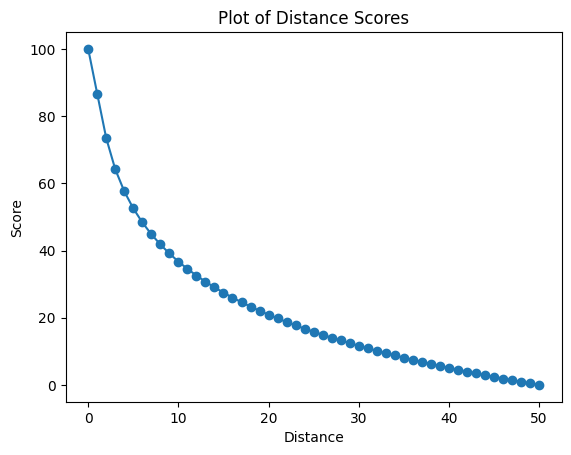

In [ ]:
import matplotlib.pyplot as plt

test_distances = [0, 1 , 1.5, 5, 40, 50, 70]
for td in test_distances:
  print("Distance: " + str(td) + "\n Score: " + str(calculate_score(td)))

test_results = []

for n in range(0,51):
  score = calculate_score(n)
  test_results.append((n, score))

x_values, y_values = zip(*test_results)
plt.plot(x_values, y_values, marker='o', linestyle='-')
plt.xlabel('Distance')
plt.ylabel('Score')
plt.title('Plot of Distance Scores')
plt.show()


In [ ]:
distance_scores_df = pd.DataFrame(columns=['electoral_area', 'metric_key', 'distance_score'])

for index, electoral_area_row in median_result.iterrows():
  library_score = calculate_score(electoral_area_row["closest_library_dist_km_median"])
  school_score = calculate_score(electoral_area_row["closest_library_dist_km_median"])
  strongstart_school_score = calculate_score(electoral_area_row["closest_strongstart_school_dist_km_median"])
  adult_education_score = calculate_score(electoral_area_row["closest_adult_education_school_dist_km_median"])
  postsecondary_school_score = calculate_score(electoral_area_row["closest_postsecondary_school_dist_km_median"])

  electoral_area_score = (library_score + school_score + strongstart_school_score + adult_education_score + postsecondary_school_score) / 5
  new_row = [electoral_area_row["electoral_area"], "median_distance_score", electoral_area_score]
  distance_scores_df.loc[len(distance_scores_df)] = new_row

distance_scores_df['distance_score'] = distance_scores_df['distance_score']/10
distance_scores_df

,electoral_area,metric_key,distance_score
0,Vancouver-Fraserview,median_distance_score,7.951367
1,Vancouver-Hastings,median_distance_score,7.999958
2,Vancouver-Kensington,median_distance_score,8.251642
3,Vancouver-Langara,median_distance_score,7.877873
4,Vancouver-Little Mountain,median_distance_score,8.373820
5,Vancouver-Point Grey,median_distance_score,6.653261
6,Vancouver-Quilchena,median_distance_score,6.660691
7,Vancouver-Renfrew,median_distance_score,8.119015
8,Vancouver-South Granville,median_distance_score,7.288850
9,Vancouver-Strathcona,median_distance_score,9.039126


## Calculate overall Vancouver distance score

In [ ]:
total_distance_score = distance_scores_df['distance_score'].mean()

vancouver_row = 'Vancouver', 'total_distance_score', total_distance_score
distance_scores_df.loc[len(distance_scores_df)] = vancouver_row

distance_scores_df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Final Data/electoral_area_with_distance_scores.csv')

# EXPORTING DATA

Go to 'export_community_metrics' notebook

## 1. Specify release version

In [ ]:
import pandas as pd
from datetime import datetime
# Get the current date and time
current_date = datetime.now().strftime("%d%b%Y")
current_date2 = datetime.now().strftime("%d-%b-%Y")


headers = ['id', 'release_name', 'release_date']

# SET VERSIONING
RELEASE_ID = 0
VERSION_NUMBER = 0.0
RELEASE_NAME = f'Rel{VERSION_NUMBER}_{current_date}'
RELEASE_DATE = current_date2

version_df = pd.DataFrame(columns=headers)
new_row = {'id': RELEASE_ID, 'release_name': RELEASE_NAME, 'release_date': RELEASE_DATE}
version_df = version_df.append(new_row, ignore_index=True)

version_df

<ipython-input-78-b5bb979931f3>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  version_df = version_df.append(new_row, ignore_index=True)


,id,release_name,release_date
0,0,Rel0.0_22Nov2023,22-Nov-2023


## 2. Output regions and ids


In [ ]:
regions_df = pd.DataFrame()
regions = properties_df.sort_values("electoral_area")['electoral_area'].unique()

for index, region in enumerate(regions):
  region_row = {"id": index, "region": region}
  regions_df = pd.concat([regions_df, pd.DataFrame([region_row])], axis=0)

regions_df

,id,region
0,0,Vancouver-Fraserview
0,1,Vancouver-Hastings
0,2,Vancouver-Kensington
0,3,Vancouver-Langara
0,4,Vancouver-Little Mountain
0,5,Vancouver-Point Grey
0,6,Vancouver-Quilchena
0,7,Vancouver-Renfrew
0,8,Vancouver-South Granville
0,9,Vancouver-Strathcona


## 3. Output Index Names

In [ ]:
index_names = ['Education', 'Health', 'Housing']

index_names_df = pd.DataFrame()

for index, index_name in enumerate(index_names):
  index_name_row = {"id": index, "index_name": index_name}
  index_names_df = pd.concat([index_names_df, pd.DataFrame([index_name_row])], axis=0)

index_names_df

,id,index_name
0,0,Education
0,1,Health
0,2,Housing


## 4. Output Regional Data

In [ ]:
headers =["release_id_fk","region_id_fk","index_id_fk","calculation_type","metric_key","metric_entity","metric_value","metric_unit"]

results_df = pd.DataFrame(columns=headers)

# VARIABLES TO SET MANUALLY
AGGREGATE = 'median'
INDEX = 'Education'
CALCULATION_TYPE = "distance"
metric_unit = 'km'

# Get variables
release_id_fk = RELEASE_ID
metric_key = f'closest_distance_{AGGREGATE}'
index_id_fk = index_names_df[index_names_df['index_name'] == INDEX]['id']

# Calculate aggregate
median_result = aggregate_and_rename(properties_df, AGGREGATE)

# Melt aggregate df
value_cols = []
id_cols = []
for col in median_result.columns:
  if "km" in col:
    value_cols.append(col)
  elif 'area' in col:
    id_cols.append(col)

melted_df = pd.melt(median_result, id_vars=id_cols, value_vars=value_cols)

for index, row in melted_df.iterrows():
  region_id_fk = regions_df[regions_df['region'] == row['electoral_area']]['id']
  metric_entity = row['variable'].split('_')[1]
  if metric_entity == 'school':
    metric_entity = metric_entity + 's'
  metric_value = row['value']

  new_row = {"release_id_fk":release_id_fk, "region_id_fk": region_id_fk, "index_id_fk": index_id_fk, "calculation_type": CALCULATION_TYPE, "metric_key": metric_key, "metric_entity": metric_entity, "metric_value": metric_value, "metric_unit": metric_unit}
  results_df = pd.concat([results_df, pd.DataFrame(new_row)], axis=0)

results_df.sort_values(by='region_id_fk')


,release_id_fk,region_id_fk,index_id_fk,calculation_type,metric_key,metric_entity,metric_value,metric_unit
0,0,0,0,distance,closest_distance_median,library,0.806480,km
0,0,0,0,distance,closest_distance_median,strongstart,0.623229,km
0,0,0,0,distance,closest_distance_median,adult,2.760365,km
0,0,0,0,distance,closest_distance_median,school,0.354223,km
0,0,0,0,distance,closest_distance_median,postsecondary,3.548811,km
0,0,1,0,distance,closest_distance_median,adult,2.769974,km
0,0,1,0,distance,closest_distance_median,strongstart,1.035359,km
0,0,1,0,distance,closest_distance_median,postsecondary,1.617753,km
0,0,1,0,distance,closest_distance_median,school,0.301255,km
0,0,1,0,distance,closest_distance_median,library,1.132071,km


# OUTPUT ALL DATA TO EXCEL SHEET

In [ ]:
current_date = datetime.now().strftime("%d-%b-%Y")

output_file_name = f'/content/gdrive/MyDrive/Colab Notebooks/Final Data/results_data_{current_date}.xlsx'

with pd.ExcelWriter(output_file_name) as writer:
    # Write each dataframe to a different sheet
    version_df.to_excel(writer, sheet_name='releases', index=False)
    regions_df.to_excel(writer, sheet_name='regions', index=False)
    index_names_df.to_excel(writer, sheet_name='indexes', index=False)
    results_df.to_excel(writer, sheet_name='region_metrics', index=False)

In [ ]:
# Stop execution here
if blah then stop :) :)

In [ ]:
## CURRENTLY NOT WORKING - optimised way of finding closest distance using kdtree

In [ ]:
class Node:
    def __init__(self, point, index, left=None, right=None):
        self.point = point
        self.index = index
        self.left = left
        self.right = right

def build_kdtree(points, indices=None, depth=0):
    if not points:
        return None

    k = len(points[0])  # Assuming all points have the same dimensionality

    if indices is None:
        indices = list(range(len(points)))

    # Alternate between dimensions as you go deeper into the tree
    axis = depth % k

    # Sort points and choose median as pivot element
    points, indices = zip(*sorted(zip(points, indices), key=lambda x: x[0][axis]))
    median = len(points) // 2

    # Create node and construct subtrees
    return Node(
        point=points[median],
        index=indices[median],
        left=build_kdtree(points[:median], indices[:median], depth + 1),
        right=build_kdtree(points[median + 1:], indices[median + 1:], depth + 1)
    )

def nearest_neighbor_search(tree, target, best=None, best_index=None, depth=0):
    if tree is None:
        return best, best_index

    k = len(target)
    axis = depth % k

    next_best = None
    next_branch = None

    if best is None or distance(target, best) > distance(target, tree.point):
        next_best = tree.point
        next_best_index = tree.index
    else:
        next_best = best
        next_best_index = best_index

    if target[axis] < tree.point[axis]:
        next_branch = tree.left
    else:
        next_branch = tree.right

    return nearest_neighbor_search(next_branch, target, next_best, next_best_index, depth + 1)


def distance(point1, point2):
    return sum((p1 - p2) ** 2 for p1, p2 in zip(point1, point2)) ** 0.5


# Example usage
points = [(2,3), (5,4), (9,6), (4,7), (8,1), (7,2)]
tree = build_kdtree(points)
query_point = (9,2)
nearest_point, nearest_index = nearest_neighbor_search(tree, query_point)
print(nearest_point, nearest_index)

In [ ]:
# import scipy
# from scipy.spatial import KDTree

# Assuming libraries and addresses are lists of tuples (latitude, longitude)
libraries_df['lat_lon'] = libraries_df['geo_point_2d'].apply(literal_eval)
properties_df['lat_lon'] = properties_df['geo_point_2d'].apply(literal_eval)

libraries = libraries_df['lat_lon']  # List of library locations
properties = properties_df['lat_lon']  # List of addresses

# Create a KD tree for the library locations
kdtree = build_kdtree(libraries.tolist())

# def find_nearest_library(address):
#     # Query the KD tree to find the index of the nearest library
#     dist, idx = nearest_neighbor_search(kdtree, address)

#     # Return the nearest library and its distance
#     return libraries[idx], dist

# Example usage
for address_point in properties.tolist():
    nearest_library, distance = nearest_neighbor_search(kdtree, address_point)
    print(address_point, nearest_library, distance)


In [ ]:
%pip install scipy


In [ ]:
for index, row in libraries_df[1:5].iterrows():
    smallest_distance = 999
    lat1, lon1 = literal_eval(row['geo_point_2d'])
    for index2, row2 in properties_df[1:5].iterrows():
        lat2, lon2 = literal_eval(row2['geo_point_2d'])
        distance = haversine(lat1, lon1, lat2, lon2)
        if distance < smallest_distance:
            smallest_distance = distance
            print(row2['Geo Local Area'])
            print(row['NAME'])
        print(smallest_distance)

